In [2]:
!pip install roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("my-first-project-fmp4x")
dataset = project.version(12).download("yolov8")

print(f"Dataset location: {dataset.location}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-12 in yolov8:: 100%|██████████| 100/100 [00:00<00:00, 2431.31it/s]

Dataset location: /content/My-First-Project-12


In [3]:
!pip install pillow-heif==0.10.0



  Using cached pillow_heif-0.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
Using cached pillow_heif-0.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.3 MB)
  Attempting uninstall: pillow-heif
    Found existing installation: pillow_heif 1.0.0
    Uninstalling pillow_heif-1.0.0:
      Successfully uninstalled pillow_heif-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.66 requires pillow-heif>=0.18.0, but you have pillow-heif 0.10.0 which is incompatible.


In [3]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from collections import Counter
import random

label_dir = os.path.join(dataset.location, "train", "labels")
image_dir = os.path.join(dataset.location, "train", "images")
cropped_output_dir = "cropped_dataset"
os.makedirs(cropped_output_dir, exist_ok=True)

In [4]:
def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2

In [5]:
def apply_augmentations(crop):
    angle = random.choice([0, 90, 180, 270])
    angle=angle + (np.random.random_integers(0,15))
    if angle:
        crop = np.rot90(crop, k=angle // 90)

    crop = cv2.GaussianBlur(crop, (5, 5), 0)
    noise = np.random.normal(0, 0.1, crop.shape).astype(np.uint8)
    crop = cv2.add(crop, noise)

    return crop

In [6]:

rare_classes = [0, 2,4]  # Modify as needed
augment_factor = 4

class_counter = Counter()

for label_file in tqdm(glob(f"{label_dir}/*.txt")):
    image_file = label_file.replace('/labels/', '/images/').replace('.txt', '.jpg')
    img = cv2.imread(image_file)
    h, w = img.shape[:2]

    with open(label_file, "r") as f:
        lines = f.readlines()

        for idx, line in enumerate(lines):
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)

            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            class_folder = os.path.join(cropped_output_dir, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            filename = os.path.basename(image_file).replace('.jpg', f'_{idx}.jpg')
            cv2.imwrite(os.path.join(class_folder, filename), crop)
            class_counter[class_id] += 1

            if class_id in rare_classes:
                for aug_idx in range(augment_factor):
                    aug_crop = apply_augmentations(crop)
                    aug_filename = os.path.basename(image_file).replace('.jpg', f'_{idx}_aug{aug_idx}.jpg')
                    cv2.imwrite(os.path.join(class_folder, aug_filename), aug_crop)
                    class_counter[class_id] += 1

print("Class distribution after cropping and augmentation:", class_counter)


100%|██████████| 36/36 [00:03<00:00, 11.03it/s]

Class distribution after cropping and augmentation: Counter({1: 7631, 3: 667, 5: 287, 4: 165, 0: 60, 2: 15})


In [7]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
import shutil

classification_dir = "classification_dataset"
os.makedirs(classification_dir, exist_ok=True)

for class_id in os.listdir(cropped_output_dir):
    class_path = os.path.join(cropped_output_dir, class_id)
    images = glob(os.path.join(class_path, '*.jpg'))

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for phase, img_paths in [('train', train_imgs), ('val', val_imgs)]:
        phase_class_dir = os.path.join(classification_dir, phase, class_id)
        os.makedirs(phase_class_dir, exist_ok=True)

        for img_path in img_paths:
            shutil.copy(img_path, phase_class_dir)

print("Dataset structured for YOLO classification at:", classification_dir)


Dataset structured for YOLO classification at: classification_dataset


In [8]:
pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [9]:
import torch
import torchvision
from torchvision import transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the data
train_data = torchvision.datasets.ImageFolder(root="/content/classification_dataset/train", transform=transform)
test_data = torchvision.datasets.ImageFolder(root="/content/classification_dataset/val", transform=transform)

# Define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

In [10]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

In [11]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

# --- 1. Load the pre-trained ResNet50 model ---
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# --- 2. Freeze all layers in the network ---
# We start by making the entire model non-trainable.
print("Freezing all model layers...")
for param in model.parameters():
    param.requires_grad = False

# --- 3. Unfreeze the last two blocks (layer3 and layer4) ---
# This is the core of the "balanced approach".
print("Unfreezing layers in 'layer3' and 'layer4'...")
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

# --- 4. Replace the final classifier head ---
# The new fully connected layer will be trainable by default.
print("Replacing the final classifier head...")
num_features = model.fc.in_features
# The number of output classes is determined from your train_data
num_classes = len(train_data.classes)
model.fc = nn.Linear(num_features, num_classes)

# --- 5. Define loss function and move model to device ---
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- 6. Set up the Optimizer with Differential Learning Rates ---
# This is a critical best practice for fine-tuning. We use a lower
# learning rate for the pre-trained layers and a higher one for the new classifier.
print("Setting up optimizer with differential learning rates...")
pre_trained_params = list(model.layer3.parameters()) + list(model.layer4.parameters())
new_classifier_params = model.fc.parameters()

optimizer = optim.Adam([
    {'params': pre_trained_params, 'lr': 1e-5},      # Very low LR for the convolutional layers
    {'params': new_classifier_params, 'lr': 1e-3}    # Higher LR for the new classifier head
])

print("\nModel setup complete and ready for training!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.4MB/s]


Freezing all model layers...
Unfreezing layers in 'layer3' and 'layer4'...
Replacing the final classifier head...
Setting up optimizer with differential learning rates...

Model setup complete and ready for training!


In [12]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model_weights.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'best_model_weights.pth'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
# --- Initialize Early Stopping ---
# We'll stop training if validation loss doesn't improve for 5 epochs.
# We'll save the best model to 'resnet_finetuned_best.pth'.
# `verbose=True` will print a message each time the model is saved.
patience = 5
early_stopper = EarlyStopping(patience=patience, verbose=True, path='resnet_finetuned_best.pth')

# Define the number of epochs
num_epochs = 50 # You can set a higher number, early stopping will handle the rest

# --- Main Training Loop with Early Stopping ---
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # --- Validation Phase ---
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)

    # --- Calculate Average Losses and Accuracy ---
    train_loss /= len(train_data)
    test_loss /= len(test_data)
    test_acc = test_acc.double() / len(test_data)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")

    # --- Early Stopping Check ---
    # Call the early stopper instance at the end of each epoch
    early_stopper(test_loss, model)

    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

# --- Post-Training ---
print("\nTraining finished.")
print(f"Best model saved to: {early_stopper.path}")

# To use the best model for inference later, you can load the saved weights:
# model.load_state_dict(torch.load('resnet_finetuned_best.pth'))

Epoch [1/50] Train Loss: 0.5062 Test Loss: 0.4165 Test Acc: 0.8704
Validation loss decreased (inf --> 0.416493).  Saving model ...
Epoch [2/50] Train Loss: 0.3817 Test Loss: 0.3824 Test Acc: 0.8879
Validation loss decreased (0.416493 --> 0.382354).  Saving model ...
Epoch [3/50] Train Loss: 0.3127 Test Loss: 0.3592 Test Acc: 0.8925
Validation loss decreased (0.382354 --> 0.359233).  Saving model ...
Epoch [4/50] Train Loss: 0.2585 Test Loss: 0.3606 Test Acc: 0.8947
EarlyStopping counter: 1 out of 5
Epoch [5/50] Train Loss: 0.2036 Test Loss: 0.3731 Test Acc: 0.8942
EarlyStopping counter: 2 out of 5
Epoch [6/50] Train Loss: 0.1577 Test Loss: 0.3743 Test Acc: 0.8851
EarlyStopping counter: 3 out of 5
Epoch [7/50] Train Loss: 0.1196 Test Loss: 0.4145 Test Acc: 0.8930
EarlyStopping counter: 4 out of 5
Epoch [8/50] Train Loss: 0.0904 Test Loss: 0.4242 Test Acc: 0.8913
EarlyStopping counter: 5 out of 5
Early stopping triggered

Training finished.
Best model saved to: resnet_finetuned_best.pth


In [ ]:
!pip install optuna -q

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from optuna.trial import TrialState


# --- Dependency: EarlyStopping Class ---
# Including the EarlyStopping class here so the cell is self-contained.
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model_weights.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# --- 1. Define the Objective Function for Optuna ---
# This function encapsulates one full training run. Optuna will call it for each trial.
def objective(trial):
    # --- Device Configuration ---
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # --- Hyperparameter Search Space ---
    # We define the range of hyperparameters for Optuna to explore.
    lr_backbone = trial.suggest_float("lr_backbone", 1e-6, 1e-4, log=True)
    lr_head = trial.suggest_float("lr_head", 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    early_stopping_patience = trial.suggest_int("patience", 5, 10)

    # --- Model Setup (The "Balanced Approach") ---
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(train_data.classes))
    model = model.to(device)

    # --- Optimizer and Loss Function ---
    pre_trained_params = list(model.layer3.parameters()) + list(model.layer4.parameters())
    new_classifier_params = model.fc.parameters()

    if optimizer_name == "Adam":
        optimizer = optim.Adam([
            {'params': pre_trained_params, 'lr': lr_backbone},
            {'params': new_classifier_params, 'lr': lr_head}
        ])
    else: # SGD
        optimizer = optim.SGD([
            {'params': pre_trained_params, 'lr': lr_backbone, 'momentum': 0.9},
            {'params': new_classifier_params, 'lr': lr_head, 'momentum': 0.9}
        ])

    criterion = nn.CrossEntropyLoss()

    # --- Initialize Early Stopping for this trial ---
    # Each trial gets its own early stopper and saved model file.
    trial_model_path = f'trial_{trial.number}_best_model.pth'
    early_stopper = EarlyStopping(patience=early_stopping_patience, verbose=False, path=trial_model_path)

    # --- Training & Validation Loop ---
    num_epochs = 25 # Set a max number of epochs; early stopping will likely finish sooner
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        epoch_val_loss = test_loss / len(test_data)
        epoch_val_acc = correct / total

        # --- Report intermediate results to Optuna Pruner ---
        trial.report(epoch_val_acc, epoch)

        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Handle early stopping
        early_stopper(epoch_val_loss, model)
        if early_stopper.early_stop:
            print(f"Trial {trial.number}: Early stopping triggered at epoch {epoch+1}")
            break

    # Return the best validation accuracy achieved in this trial
    # The best score from early_stopper is -val_loss_min, we can use that to find best accuracy.
    # But since we reported accuracy at each step, Optuna already knows the best value.
    # We will just return the last reported accuracy.
    return epoch_val_acc


# --- 2. Create and Run the Optuna Study ---
# A pruner is used to stop unpromising trials early.
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

# Start the optimization process.
# `n_trials` is the number of different hyperparameter combinations to test.
study.optimize(objective, n_trials=25)


# --- 3. Print the Results ---
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("\n--------------------------------------------------")
print("Study statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

print("\nBest trial:")
best_trial = study.best_trial
print(f"  Value (Max Validation Accuracy): {best_trial.value:.4f}")

print("\n  Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-29 17:28:03,074] A new study created in memory with name: no-name-f9c06fd0-7e08-4edc-b7ed-1050ca095b45


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10


Number of classes: 6
Class names: ['0', '1', '2', '3', '4', '5']

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.90      1.00      0.95      1527
           2       0.00      0.00      0.00         3
           3       0.38      0.04      0.07       134
           4       0.76      0.85      0.80        33
           5       0.75      0.26      0.38        58

    accuracy                           0.89      1767
   macro avg       0.58      0.47      0.48      1767
weighted avg       0.85      0.89      0.86      1767


Generating Confusion Matrix...


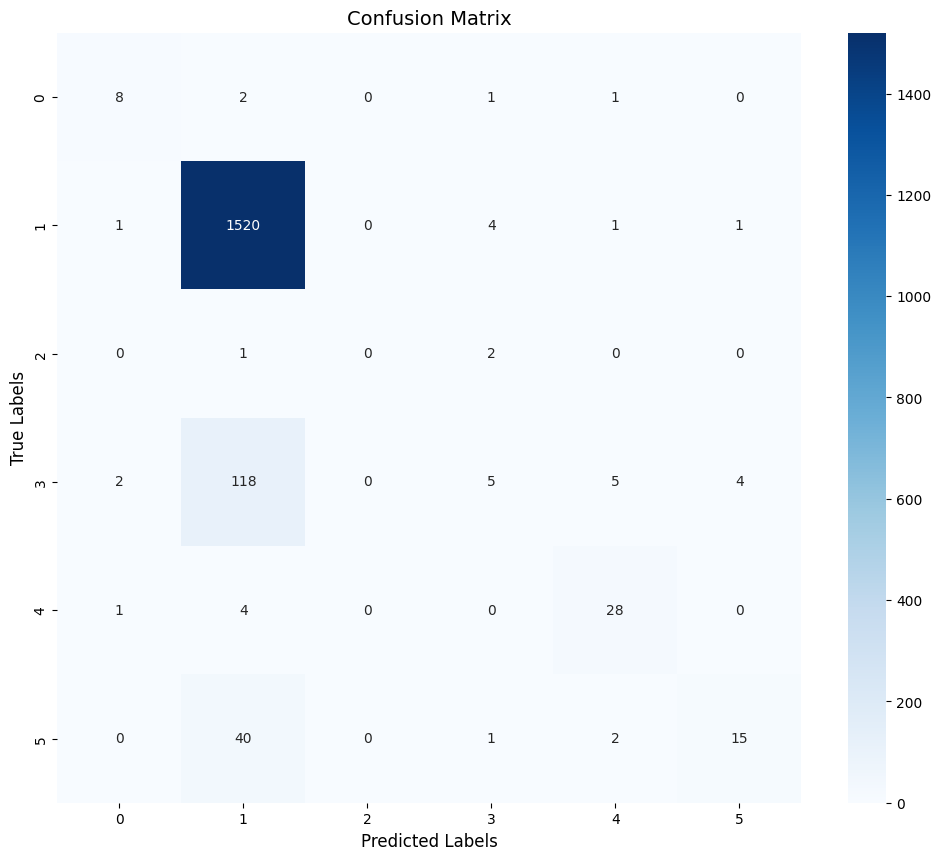

In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define and Load the Model ---
# This part remains the same.
num_classes = len(train_data.classes)
class_names = train_data.classes
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

model = resnet50()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

model_weights_path = 'resnet_finetuned_best.pth'
model.load_state_dict(torch.load(model_weights_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# --- 2. Get Predictions on the Test Set ---
# This part remains the same.
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 3. Print Classification Report ---
# This part remains the same and is still very useful.
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# --- 4. Generate and Plot the NORMALIZED Confusion Matrix ---
print("\nGenerating Normalized Confusion Matrix...")

# KEY CHANGE: Use normalize='true' to get proportions instead of counts.
cm = confusion_matrix(all_labels, all_preds, normalize='true')

plt.figure(figsize=(12, 10))

# KEY CHANGE: Change the format of the annotations to show percentages.
# fmt='.2f' will display the values as floating-point numbers with 2 decimal places.
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.show()